<font size="5"> **Stable Diffusion Inference for Text2Image on Intel Sapphire Rapids** </font> 
<br>
This code sample will perform stable diffusion inference based on the text prompt using KerasCV implementation while using Intel® Extension for Tensorflow*. The following run cases are executed:<br>
* FP32 (baseline) <br>
* Advanced AMP for BF16 <br>

<font size="5">**Environment Setup**</font>  <br>
Ensure the tensorflow_cpu kernel is activated before running this notebook.

In [1]:
import keras_cv

2023-07-26 02:15:35.274782: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-26 02:15:35.360799: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 02:15:35.889429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 02:15:35.892480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 02:15:38.115175: W tensorflow/compiler/tf2t

In [2]:
keras_cv

<module 'keras_cv' from '/home/u103722/devsummit-sea-2023/itex_cpu/lib/python3.10/site-packages/keras_cv/__init__.py'>

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#os.environ['ITEX_XPU_BACKEND'] = 'CPU'

import time
from keras_cv.models.stable_diffusion import StableDiffusion
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#import intel_extension_for_tensorflow as itex

<font size ="5">**Helper Functions**</font>

The functions below will help us plot the images.

In [4]:
def plot_images(images):
    png_name = "{}_{}imgs_{}steps.png".format(
        precision, batch_size, num_steps)
    
    print("Start plotting the generated images to %s" % (png_name))
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

<font size ="5">**Model Loading**</font> <br>
First, we construct a model and also define few of the required parameters:</font>

In [5]:
iterations = 2
use_xla = False
precision = 'fp32'
batch_size = 1
num_steps = 50
seed= 12345
benchmark_result = []

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,
    precision=precision,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


<font size ="5">**Running Inference** </font> <br>
Next, we give it a prompt:

Start Warmup


2023-07-26 02:16:25.017798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


text_encoder before:  [dtype('float32')]


2023-07-26 02:16:42.307757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


50/50 [==============================] - 87s 1s/step


2023-07-26 02:17:54.632791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


Start running inference and generating images
50/50 [==============================] - 61s 1s/step
FP32 precision: 69.10 seconds
Start plotting the generated images to fp32_1imgs_50steps.png


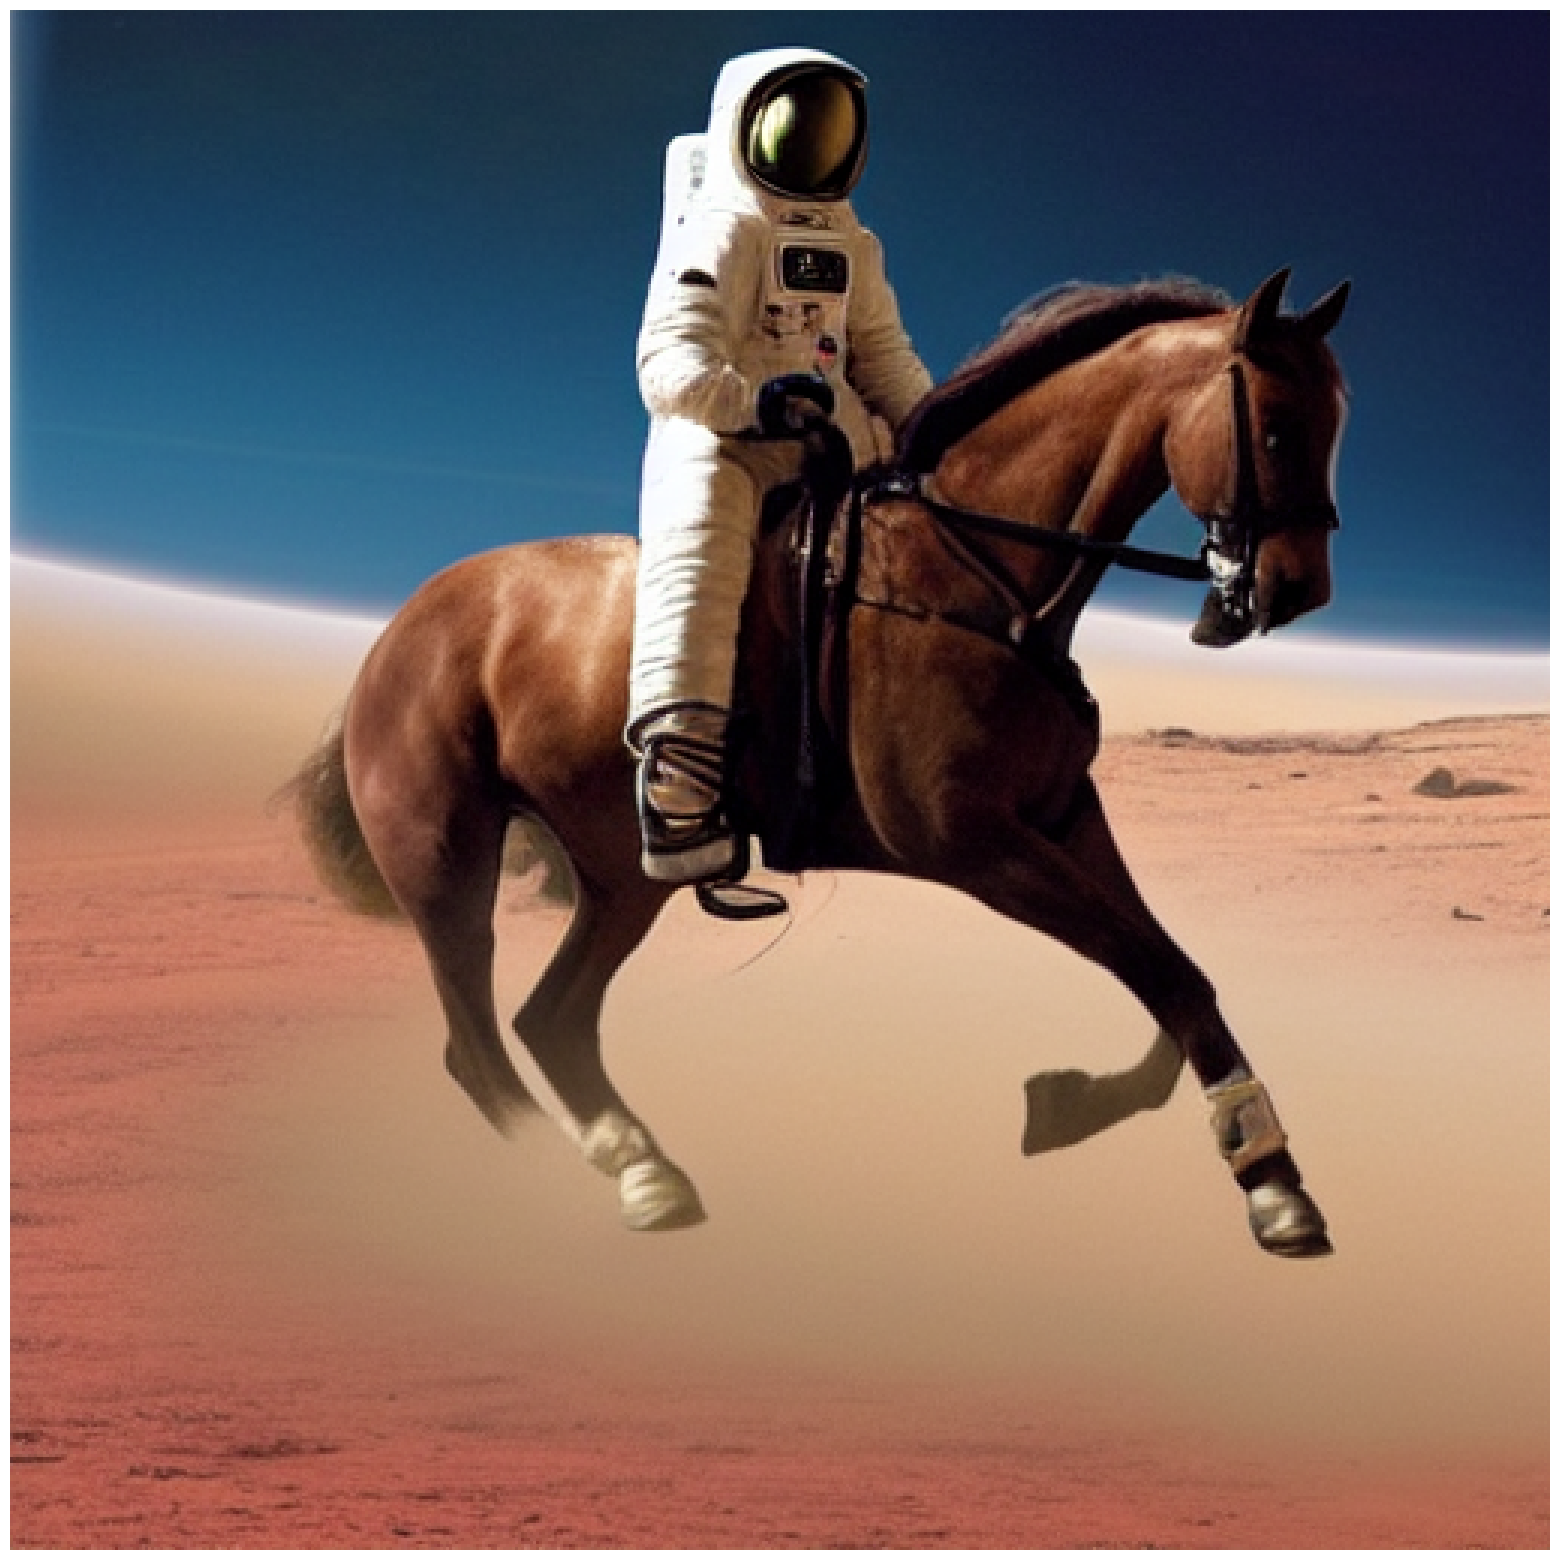

In [6]:
prompt = "a photo of an astronaut riding a horse on mars"

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed, num_steps=num_steps)
    t+=(time.time() - start_time)
print(f"FP32 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["FP32 precision", t/iterations])
plot_images(images)

<font size="4">**Performance computation using AMP BF16 precision** </font>
<br>
Enable Advanced AMP

In [7]:
import intel_extension_for_tensorflow as itex
print("intel_extension_for_tensorflow {}".format(itex.__version__))

auto_mixed_precision_options = itex.AutoMixedPrecisionOptions()
auto_mixed_precision_options.data_type = itex.BFLOAT16 #itex.FLOAT16

graph_options = itex.GraphOptions(auto_mixed_precision_options=auto_mixed_precision_options)
graph_options.auto_mixed_precision = itex.ON

config = itex.ConfigProto(graph_options=graph_options)
itex.set_config(config)

ModuleNotFoundError: No module named 'keras.engine'

In [ ]:
model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla
)

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed, num_steps=num_steps)
    t+=(time.time() - start_time)
    
print(f"AMP BF16 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["AMP BF16 precision", t/iterations])
plot_images(images)

<font size ="5">**Performance comparison** <br></font>
Lets compare the results wrt inference latency time.

In [ ]:
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

In [ ]:
import matplotlib.pyplot as plt

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("Stable diffusion Inference Time")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "BF16"], [benchmark_result[0][1], benchmark_result[1][1]])

In [ ]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')